# Optimizing numerical Python code using Cython

### Code Corner, Institute of Astronomy, 07/11/2017

#### by Bjoern Soergel

NB: This is based on a longer workshop about Python optimization that I gave for the other students earlier this year. 
There I was also talking about other Python optimization tools (e.g. numba) and some simple ways of parallel programming in Python.
The Jupyter notebooks from this workshop are available here: http://www.ast.cam.ac.uk/~bs538/programming.html. 

After testing various options for making numerical Python code fast, Cython is my clear favourite. For my current main project, all numerically expensive parts are written as Cython extensions.

## Some general points about Cython:
- Cython is a superset of the Python language. The most notable new feature are static type definitions.
- Cython can be used to created compiled C extensions from Python-like code.
- It integrates seamlessly with numpy arrays, making it a great tool for speeding up the performance critical parts of our Python code.
- It can also be used for wrapping existing C/C++ libraries in Python. (But I am not going to talk about this in more detail today.)
- It is a mature project and a well-established part of the scientific Python stack.
- Do not confuse it with CPython (the standard Python implementation written in C we all use).

## Installation
Cython is included in the Anaconda Python distribution. It can also be installed via pip.

## Cython compilation workflow:
- Step 1: Cythonize: Translate Cython source file (.pyx) into C source code.
- Step 2: Compile .c source code
- Step 3: Import extension into Python


Fortunately we can automate these steps, and they also integrate with Jupyter notebooks.

## Using Cython to optimize numerical Python code:

### Some general remarks about optimizing code:

Here is the procedure I would recommend for optimizing a piece of numerical code.

- Remember the 80/20 principle: For a typical code, 80% of the runtime will be spent in at most 20% of the code. Don't waste your time optimizing anything but the critical 20%. 
- Profile your code to find out what the bottleneck is. In Jupyter notebooks, we can e.g. use the %timeit and %%time magic for that.
- Before you start coding, think/research if there is a better algorithm of doing the same thing. Again, we don't want to waste our time optimizing a bad algorithm.
- Don't parallelize blindly, first optimize on a single CPU.
- Check carefully that the optimized version still gives the same result.

For the sake of this tutorial we focus exclusively on optimizing a given piece of code, but profiling and the algorithm are equally important!

## Worked example: Contaminant removal on the sphere

#### Setup:
- one catalogue with coordinates of objects of interest
- second catalogue with coordinates of contaminants
- want to flag all objects of interest that are closer than a certain angular distance to a contaminant object

NB: There are built-in functions in scipy and astropy to do exactly this computation, but that's not the point here. 

## Setup: generate random points

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#helper function to generate points
def gen_points_sphere(n):
    """
    generate random points on sphere
    """
    #angles
    costheta = 2*np.random.rand(n)-1
    theta = np.arccos(costheta)
    phi = 2*np.pi*np.random.rand(n)
    #unit vectors on the sphere
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    vec = np.array([x,y,z]).T
    return vec,theta,phi

n = 100000
vec,theta,phi = gen_points_sphere(n)

The next cell is just for visualization and can be commented if you do not have healpy installed.

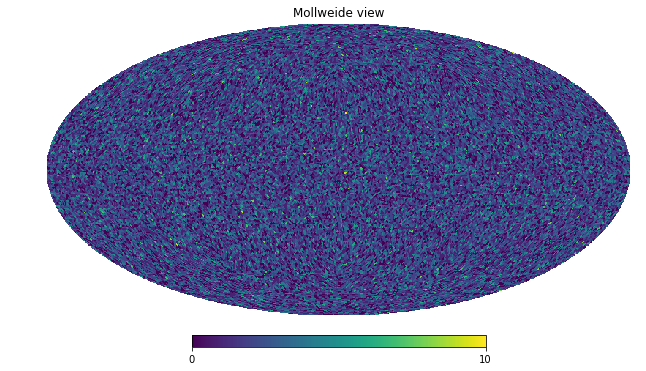

In [3]:
import healpy as hp
def skymap(theta,phi,nside): 
    """
    creates healpix map of density on the sky
    """
    ipix = hp.ang2pix(nside,theta,phi)
    testmap = np.bincount(ipix,minlength=hp.nside2npix(nside))
    return testmap
        
testmap = skymap(theta,phi,64)
hp.mollview(testmap)

Generate the populations for the example. We begin with a small number of objects.

In [5]:
# objects (obj)
vec_obj,theta_obj,phi_obj = gen_points_sphere(5000) # ~500,000 in my real use case
# contaminants (ps)
vec_ps,theta_ps,phi_ps = gen_points_sphere(500) # ~50,000 in my real use case
print(vec_obj.shape,vec_ps.shape)
# maximum separation: 
maxsep_deg = 1.
cos_maxsep = np.cos(np.deg2rad(maxsep_deg))

(5000, 3) (500, 3)


## Algorithm:

If we represent our points by 3D unit vectors, then $ \cos (\Delta \sigma) = \bf{n}_1 \dot \bf{n}_2$. We therefore only need compute one dot product per pair, which is faster then computing the great-circle distance.

NB: For large N a k-d tree is more efficient (this is what the astropy version uses internally. But for the sake of having an example that is easy to implement, let's stick with the dot product (2).

## Implementations

### 1) Naive Python
(we all know that for loops in Python are slow)

NB: For convenience we are still using numpy arrays as input and output (we could do the same with lists though). The core of the computation is however in pure Python.

In [6]:
def angdistcut_python_naive(vec_obj,vec_ps,cos_maxsep):
    nobj = vec_obj.shape[0]
    nps = vec_ps.shape[0]
    dim = vec_obj.shape[1]
    #objects to be deleted
    out = []
    for i in range(nobj):
        for j in range(nps):
            cos = 0.
            #compute dot product
            for k in range(dim):
                cos += vec_obj[i,k] * vec_ps[j,k]
            #stop once we have found one contaminant
            if cos > cos_maxsep:
                out.append(i)
                break   
    return np.array(out)

In [7]:
%%time
result_python_naive = angdistcut_python_naive(vec_obj,vec_ps,cos_maxsep)

CPU times: user 3.94 s, sys: 4 ms, total: 3.95 s
Wall time: 3.95 s


#### NB: All timing-related statements may vary depending on your machine.

### 2) Numpy

This is a more sensible solution making use of the numpy-builtins.

In [8]:
def angdistcut_numpy(vec_obj,vec_ps,cos_maxsep):
    nobj = vec_obj.shape[0]
    nps = vec_ps.shape[0]
    # fast vectorized way to compute dot product
    # (looses the advantage of stopping once one contaminant is found)
    # (but the numpy speed gains easily outweigh that)
    cos_arr = np.einsum('ik,jk->ij',vec_obj,vec_ps)
    # number of contaminants per object
    temp = (cos_arr > cos_maxsep).sum(axis=1)
    #indices of objects that should be removed
    out = np.flatnonzero(temp)
    return out

In [9]:
%%time
result_numpy = angdistcut_numpy(vec_obj,vec_ps,cos_maxsep)

CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 18.2 ms


In [10]:
# check that results agree
assert np.array_equal(result_python_naive,result_numpy)

Using numpy has given us a speed-up of a factor of ~200. This is quite typical for computations that can be vectorized efficiently.

In [12]:
# expected runtime for full sample (100 times as many objects and contaminants)
20e-3*100*100/3600. #hours

0.05555555555555555

In terms of runtime, our problem is solved. However, we have not considered memory usage so far. For its vectorized computation to be efficient, numpy has to store everything in large arrays that are contiguous in memory. Simply to store the intermediate array *cos_arr* we need at least:

In [13]:
# double precision (64 bit = 8 byte per element)
# Nobj*Nps*8 
5e5*5e4*8/1e9 #in GB

200.0

Our work desktops have 16 GB, so suddenly memory becomes the bottleneck. As soon as things need to be swapped from memory to the hard drive, things become *really* slow.

On top, some numpy functions allocate larger temporary arrays "behind the scenes", making this problem even worse. 

## Enter: python optimization tools
- *numba* (numpy-aware just-in-time compiler)
- *Cython* (Python/C hybrid language, creates compiled C extension)

From my experience, the two above are the most mature and useful ones, but there are certainly other options, such as:
- other JIT compilers (Hope, Pythran, PyPy,...)
- scipy weave (importing C code into python)
- ctypes (Python/C API for C extensions)
- f2py (Fortran --> Python modules)
- ...

NB: The latter three require you to write C/C++ or Fortran code. If you are proficient in either of these, you might not run into the issue of having to optimize numerical Python code so frequently. It might still be worth learning, as Python (and also Cython) are much nicer to write than C/C++ or Fortran.

#### Today I am only showing Cython, but it is worth knowing about the others.

## Cython

Cython is a super-set of Python. It allows static type definitions, translates our Python code into C code, which we can then compile and then import as an external library (.so on linux) back into Python. In Jupyter notebooks, all this can be done automatically behind the scenes. 

Outside of Jupyter notebooks, we need to write a very short Python Makefile that handles the compilation for us, see e.g. here:
http://cython.readthedocs.io/en/latest/src/tutorial/cython_tutorial.html

In [14]:
%load_ext Cython

### Start: a cythonized version of the naive pure-Python implementation

In [15]:
%%cython -a
# -a provides annotation
# yellow annotations: calls to Python --> slow
# want to remove all yellow from our loops

#Python functions,attributes from numpy
import numpy as np
# C functions,attributes
cimport numpy as np
# Cython handles the namespace ambiguity internally in this case

def angdistcut_cython_naive(vec_obj, vec_ps, cos_maxsep):
    nobj = vec_obj.shape[0]
    nps = vec_ps.shape[0]
    dim = vec_obj.shape[1]
    #objects to be deleted
    out = []
    for i in range(nobj):
        for j in range(nps):
            cos = 0.
            #compute dot product
            for k in range(dim):
                cos += vec_obj[i,k] * vec_ps[j,k]
            #stop once we have found one contaminant
            if cos > cos_maxsep:
                out.append(i)
                break   
    return np.array(out)

In [16]:
%%time
result_cython_naive = angdistcut_cython_naive(vec_obj,vec_ps,cos_maxsep)

CPU times: user 3.36 s, sys: 16 ms, total: 3.38 s
Wall time: 3.38 s


In [17]:
assert np.array_equal(result_cython_naive,result_numpy)

Essentially all Python code is valid Cython code. But without adding type definitions we get only a very small speed-up.

### Adding static type definitions

#### Here we make use of Cython's *typed memorview*. This is a container that provides fast access to numpy-like arrays in Cython.

NB: I have also made one small change to the algorithm: instead of appending to a list I use an array to store which objects are flagged as contaminated, and at the end return the nonzero elements of that array (similar to the numpy case above.)

In [18]:
%%cython -a

import numpy as np
cimport numpy as np

def angdistcut_cython_typed(double[:,::1] vec_obj, double[:,::1] vec_ps, double cos_maxsep):
    """
    NB: double[:] --> "typed memoryview": gives fast access to numpy-like arrays in Cython
    double[:,::1] --> 2D typed memoryview, with last index varying fastest
    for this it needs to be C contigous
    """
    
    cdef:
        int nps = vec_ps.shape[0]
        int nobj = vec_obj.shape[0]
        int dim = vec_obj.shape[1]
        #use int array instead of bool
        int[:] found = np.zeros(nobj, np.int32)
        int i,j
        double cos

    for i in range(nobj):
        for j in range(nps):
            cos = (vec_obj[i,0]*vec_ps[j,0] + 
                   vec_obj[i,1]*vec_ps[j,1] + 
                   vec_obj[i,2]*vec_ps[j,2])
            if cos > cos_maxsep:
                found[i] = 1
                break
    #convert result from typed memory view into array before returning 
    return np.flatnonzero(np.asarray(found))

Because of the way we have created the input arrays, they are not C-contiguous (row-major ordering) in memory, but Fortran-contiguous (column-major ordering). If we simply input them into the Cython function, we would get an error.
Of course we could have anticipated this when creating them, but is an instructive to do this here. (For Python this is never an issue.)

In [19]:
#change memory ordering
vec_obj_c = np.ascontiguousarray(vec_obj)
vec_ps_c = np.ascontiguousarray(vec_ps)

In [20]:
%%time
result_cython_typed = angdistcut_cython_typed(vec_obj_c,vec_ps_c,cos_maxsep)

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 19.5 ms


In [21]:
assert np.array_equal(result_cython_typed,result_numpy)

With a little typing effort, we are already at roughly the same speed as the (internally highly optimized!) numpy version.

NB: again, this statement is somewhat platform dependent

### Let's add some compiler directives to optimize our Cython function for even more speed-up.

full overview of available directives:
http://cython.readthedocs.io/en/latest/src/reference/compilation.html#compiler-directives

In [22]:
%%cython -a

import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
def angdistcut_cython_opt(double[:,::1] vec_obj, double[:,::1] vec_ps, double cos_maxsep):
    """
    disabled some of the run-time checks, and also enabled C division
    the latter is pointless here, but can make large differences when divisions are involved
    """
    
    cdef:
        int nps = vec_ps.shape[0]
        int nobj = vec_obj.shape[0]
        int dim = vec_obj.shape[1]
        #use int array instead of bool
        int[:] found = np.zeros(nobj, np.int32)
        int i,j
        double cos

    for i in range(nobj):
        for j in range(nps):
            cos = (vec_obj[i,0]*vec_ps[j,0] + 
                   vec_obj[i,1]*vec_ps[j,1] + 
                   vec_obj[i,2]*vec_ps[j,2])
            if cos > cos_maxsep:
                found[i] = 1
                break
                
    return np.flatnonzero(np.asarray(found))

In [25]:
%%time
result_cython_opt = angdistcut_cython_opt(vec_obj_c,vec_ps_c,cos_maxsep)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12.4 ms


In [26]:
assert np.array_equal(result_cython_opt,result_numpy)

By adding the decorators Cython now runs significantly faster than numpy. (NB: Part of this is because our Cython implementation does not calculate any further dot products once one contaminant is found for a certain object.)

### But we can do even better by adding parallelization.
Cython has an easy integration of *OMP-parallel loops* (very similar to C,C++, Fortran). This circumvents the *Global Interpreter Lock (GIL)*, which normally prohibits the execution of parallel code in Python (for reasons related to Python's internal memory management).
More infos here: https://wiki.python.org/moin/GlobalInterpreterLock

NB: The different threads share access to the same memory. Therefore we need to make sure that our implementation is thread-safe, i.e. that different threads do not write to the same memory location.


#### Now with OMP-parallelization:

In [27]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp

import numpy as np
cimport numpy as np
cimport cython
from cython.parallel import prange, parallel

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
@cython.cdivision(True)
def angdistcut_cython_par(double[:,::1] vec_obj, double[:,::1] vec_ps, double cos_maxsep, int num_threads):
    """
    added extra compiler flags
    also added a new argument for the number of threads
    """
    
    cdef:
        int nps = vec_ps.shape[0]
        int nobj = vec_obj.shape[0]
        int dim = vec_obj.shape[1]
        #use int array instead of bool
        int[:] found = np.zeros(nobj, np.int32)
        int i,j
        double cos

    #every object is independent, so can parallelize the outer loop easily
    # need to release the GIL for that (see above)
    with nogil, parallel(num_threads=num_threads):
        #extra keyword arguments of prange control OMP settings (can fine-tune this based on our problem)
        for i in prange(nobj): #,schedule='static',chunksize=1):
            for j in range(nps):
                cos = (vec_obj[i,0]*vec_ps[j,0] + 
                       vec_obj[i,1]*vec_ps[j,1] + 
                       vec_obj[i,2]*vec_ps[j,2])
                if cos > cos_maxsep:
                    found[i] = 1
                    break
                
    return np.flatnonzero(np.asarray(found))

In [28]:
%%time
result_cython_par = angdistcut_cython_par(vec_obj_c,vec_ps_c,cos_maxsep, num_threads=2)

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 11.7 ms


In [29]:
assert np.array_equal(result_cython_par,result_numpy)

For such a small computation overhead becomes significant, therefore there is no further speedup (NB: slightly different on my work desktop). Let's repeat the benchmark with larger arrays.

### Timings with larger arrays:

In [30]:
# similar to real use case
vec_obj_large,theta_obj_large,phi_obj_large = gen_points_sphere(500000)
vec_ps_large,theta_ps_large,phi_ps_large = gen_points_sphere(50000)
#make them C contiguous again
vec_obj_large_c = np.ascontiguousarray(vec_obj_large)
vec_ps_large_c = np.ascontiguousarray(vec_ps_large)

In [31]:
%%time
result_cython_typed = angdistcut_cython_typed(vec_obj_large_c,vec_ps_large_c,cos_maxsep)

CPU times: user 19.3 s, sys: 24 ms, total: 19.3 s
Wall time: 19.3 s


In [32]:
%%time
result_cython_opt = angdistcut_cython_opt(vec_obj_large_c,vec_ps_large_c,cos_maxsep)

CPU times: user 8.26 s, sys: 8 ms, total: 8.27 s
Wall time: 8.24 s


In [33]:
%%time
result_cython_par_large = angdistcut_cython_par(vec_obj_large_c,vec_ps_large_c,cos_maxsep,num_threads=2)

CPU times: user 9.5 s, sys: 4 ms, total: 9.51 s
Wall time: 4.76 s


In [34]:
%%time
result_cython_par_large = angdistcut_cython_par(vec_obj_large_c,vec_ps_large_c,cos_maxsep,num_threads=4)

CPU times: user 18.5 s, sys: 12 ms, total: 18.5 s
Wall time: 4.66 s


#### On this laptop, I get almost linear speed-up up to 2 cores, and then no further improvement.  On the work desktop: Until 4 cores, I get a roughly linear speed-up. When using all 8 cores, there is no further speed-up.

How much speed-up OMP parallelization brings, depends both on the system and the problem. In purely CPU-bound problems (almost no memory I/O needed), one can get quasi-linear speed-up to a large number of cores.

NB: Sometimes we can squeeze out some extra speed-up by fine-tuning the 'schedule' and 'chunksize' arguments of prange. See e.g. http://cython.readthedocs.io/en/latest/src/userguide/parallelism.html

## Optimization summary

#### Python/Numpy
- The naive *pure-Python* implementation of this problem would have run for 8 hours for the full data set.
- A vectorized *numpy* version is >100 times faster, but has prohibitively large memory requirements.

#### Cython
- A statically typed *Cython* version with the appropriate decorators is faster than the numpy version and solves the memory issues.
- With a few easy modifications, we have made our *Cython* code *OMP-parallel* and gained another factor of 3.5 in speed when run on 4 cores (on my work desktop). This makes our final version several thousand times faster than the first pure-Python version. 

## Compilation outside of Jupyter notebooks:
You need the following files:
- Cython source code (.pyx). See the included example angdist.pyx.
- A simple setup.py file (Example included in this repository.)
- Then run *$ python setup.py build_ext --inplace* or put this command into a Makefile.

## Final remarks:

- Today I have only covered a small fraction of what is possible with Cython.
- There is a lot of great material on Cython on the web, e.g. here http://cython.readthedocs.io/en/latest/index.html
- I would also highly recommend the book "Cython: A Guide for Python Programmers" by Kurt Smith.